In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
cv2.__version__

'4.0.1'

In [ ]:
sift = cv.xfeatures2d.SIFT_create()

In [ ]:
surf = cv.xfeatures2d.SURF_create()

In [15]:
MIN_MATCH_COUNT = 10

img1 = cv2.imread('../Gauge/frames/frame400.jpg',0)          # queryImage
img2 = cv2.imread('../Gauge/frames/needle.PNG',0) # trainImage

# Initiate SIFT detector
#sift = cv2.SIFT()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [16]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

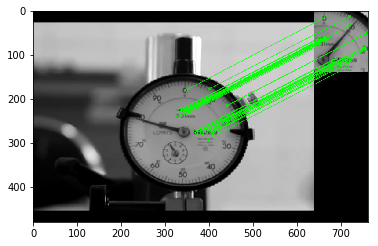

(<matplotlib.image.AxesImage at 0x2620c264630>, None)

In [17]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()

# Part 2

In [15]:
homography.shape

(3, 3)

In [1]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
from math import sqrt

homography=np.array([[7.6285898e-01,-2.9922929e-01,2.2567123e+02],[3.3443473e-01,1.0143901e+00,-7.6999973e+01],[3.4663091e-04,-1.4364524e-05,1.0000000e+00]],np.float)

"""parser = argparse.ArgumentParser(description='Code for AKAZE local features matching tutorial.')
parser.add_argument('--input1', help='Path to input image 1.', default='graf1.png')
parser.add_argument('--input2', help='Path to input image 2.', default='graf3.png')
parser.add_argument('--homography', help='Path to the homography matrix.', default='H1to3p.xml')"""



#args = parser.parse_args()
img1 = cv.imread("../Gauge/frames/needle.png", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("../Gauge/frames/frame400.jpg", cv.IMREAD_GRAYSCALE)
if img1 is None or img2 is None:
    print('Could not open or find the images!')
    exit(0)
#fs = cv.FileStorage(homography, cv.FILE_STORAGE_READ)
#homography = homography.getFirstTopLevelNode().mat()
akaze = cv.AKAZE_create()
kpts1, desc1 = akaze.detectAndCompute(img1, None)
kpts2, desc2 = akaze.detectAndCompute(img2, None)
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_BRUTEFORCE_HAMMING)
nn_matches = matcher.knnMatch(desc1, desc2, 2)
matched1 = []
matched2 = []
nn_match_ratio = 0.8 # Nearest neighbor matching ratio
for m, n in nn_matches:
    if m.distance < nn_match_ratio * n.distance:
        matched1.append(kpts1[m.queryIdx])
        matched2.append(kpts2[m.trainIdx])
        
print("matched1", matched1)
print("matched2", matched2)
inliers1 = []
inliers2 = []
good_matches = []
inlier_threshold = 2.5 # Distance threshold to identify inliers with homography check
for i, m in enumerate(matched1):
    col = np.ones((3,1), dtype=np.float64)
    col[0:2,0] = m.pt
    col = np.dot(homography, col)
    col /= col[2,0]
    dist = sqrt(pow(col[0,0] - matched2[i].pt[0], 2) +\
                pow(col[1,0] - matched2[i].pt[1], 2))
    if dist < inlier_threshold:
        good_matches.append(cv.DMatch(len(inliers1), len(inliers2), 0))
        inliers1.append(matched1[i])
        inliers2.append(matched2[i])
res = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)
cv.drawMatches(img1, inliers1, img2, inliers2, good_matches, res)
cv.imwrite("akaze_result.png", res)
inlier_ratio = len(inliers1) / float(len(matched1))
print('A-KAZE Matching Results')
print('*******************************')
print('# Keypoints 1:                        \t', len(kpts1))
print('# Keypoints 2:                        \t', len(kpts2))
print('# Matches:                            \t', len(matched1))
print('# Inliers:                            \t', len(inliers1))
print('# Inliers Ratio:                      \t', inlier_ratio)
cv.imshow('result', res)
cv.waitKey()

matched1 []
matched2 []


ZeroDivisionError: float division by zero

# part 3

In [3]:
img1 = cv.imread("../Gauge/frames/needle1.png", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("../Gauge/frames/frame1.jpg", cv.IMREAD_GRAYSCALE)
if img1 is None or img2 is None:
    print('Could not open or find the images!')
    exit(0)
#-- Step 1: Detect the keypoints using SURF Detector, compute the descriptors
minHessian = 400
detector = cv.xfeatures2d_SURF.create(hessianThreshold=minHessian)
keypoints1, descriptors1 = detector.detectAndCompute(img1, None)
keypoints2, descriptors2 = detector.detectAndCompute(img2, None)
#-- Step 2: Matching descriptor vectors with a FLANN based matcher
# Since SURF is a floating-point descriptor NORM_L2 is used
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(descriptors1, descriptors2, 2)
#-- Filter matches using the Lowe's ratio test
ratio_thresh = 0.7
good_matches = []
for m,n in knn_matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)
#-- Draw matches
img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)
cv.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, img_matches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#-- Show detected matches
plt.imshow('Good Matches', img_matches)
#cv.waitKey()

error: OpenCV(4.1.0) C:\projects\opencv-python\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1029: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


In [4]:
import numpy as np
import sys
import cv2 as cv
def show_wait_destroy(winname, img):
    cv.imshow(winname, img)
    cv.moveWindow(winname, 500, 0)
    cv.waitKey(0)
    cv.destroyWindow(winname)

# 4

In [5]:
src = cv.imread("../Gauge/frames/frame1.jpg")
# Check if image is loaded fine
if src is None:
    print ('Error opening image: ' + argv[0])
# Show source image
cv.imshow("src", src)
# [load_image]
# [gray]
# Transform source image to gray if it is not already
if len(src.shape) != 2:
    gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
else:
    gray = src
# Show gray image
show_wait_destroy("gray", gray)
# [gray]
# [bin]
# Apply adaptiveThreshold at the bitwise_not of gray, notice the ~ symbol
gray = cv.bitwise_not(gray)
bw = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, \
                            cv.THRESH_BINARY, 15, -2)
# Show binary image
show_wait_destroy("binary", bw)
# [bin]
# [init]
# Create the images that will use to extract the horizontal and vertical lines
horizontal = np.copy(bw)
vertical = np.copy(bw)
# [init]
# [horiz]
# Specify size on horizontal axis
cols = horizontal.shape[1]
horizontal_size = cols // 30
# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))
# Apply morphology operations
horizontal = cv.erode(horizontal, horizontalStructure)
horizontal = cv.dilate(horizontal, horizontalStructure)
# Show extracted horizontal lines
show_wait_destroy("horizontal", horizontal)
# [horiz]
# [vert]
# Specify size on vertical axis
rows = vertical.shape[0]
verticalsize = rows // 30
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv.getStructuringElement(cv.MORPH_RECT, (1, verticalsize))
# Apply morphology operations
vertical = cv.erode(vertical, verticalStructure)
vertical = cv.dilate(vertical, verticalStructure)
# Show extracted vertical lines
show_wait_destroy("vertical", vertical)
# [vert]
# [smooth]
# Inverse vertical image
vertical = cv.bitwise_not(vertical)
show_wait_destroy("vertical_bit", vertical)
'''
Extract edges and smooth image according to the logic
1. extract edges
2. dilate(edges)
3. src.copyTo(smooth)
4. blur smooth img
5. smooth.copyTo(src, edges)
'''
# Step 1
edges = cv.adaptiveThreshold(vertical, 255, cv.ADAPTIVE_THRESH_MEAN_C, \
                            cv.THRESH_BINARY, 3, -2)
show_wait_destroy("edges", edges)
# Step 2
kernel = np.ones((2, 2), np.uint8)
edges = cv.dilate(edges, kernel)
show_wait_destroy("dilate", edges)
# Step 3
smooth = np.copy(vertical)
# Step 4
smooth = cv.blur(smooth, (2, 2))
# Step 5
(rows, cols) = np.where(edges != 0)
vertical[rows, cols] = smooth[rows, cols]
# Show final result
show_wait_destroy("smooth - final", vertical)
# [smooth]

if cv.waitKey(1) == 27:
    cv.destroyAllWindows()

# 5

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

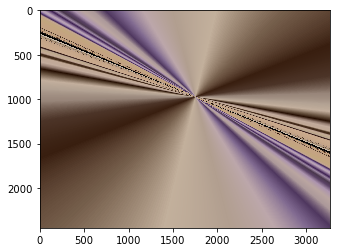

In [31]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

#img1=cv2.imread("../Gauge/frames/Video1/frame1.jpg")
img1=cv2.imread("../Gauge/data/bias_noOffset.jpg")
img2=cv2.imread("../Gauge/data/straight_noOffset.jpg")
  # Convert images to grayscale
grey1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
grey2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
 
# Detect ORB features and compute descriptors.
orb = cv2.ORB_create(MAX_FEATURES)
impts1, d1 = orb.detectAndCompute(grey1, None)
impts2, d2 = orb.detectAndCompute(grey2, None)
 
# Match features.
featurematcheObj = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matchedfeatures = featurematcheObj.match(d1, d2, None)
 
# Sort matches by score
matchedfeatures.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
GoodMatches = int(len(matchedfeatures) * GOOD_MATCH_PERCENT)
matchedfeatures = matchedfeatures[:GoodMatches]

# Draw top matches
imgMatches = cv2.drawMatches(img1, impts1, img2, impts2, matchedfeatures, None)
#cv2.imwrite("matchedfeature.jpg", imgMatches)
 
# Extract location of good matches
points1 = np.zeros((len(matchedfeatures), 2), dtype=np.float32)
points2 = np.zeros((len(matchedfeatures), 2), dtype=np.float32)

for i, feature in enumerate(matchedfeatures):
  points1[i, :] = impts1[feature.queryIdx].pt
  points2[i, :] = impts2[feature.trainIdx].pt
 
# Find homography
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

# Use homography
height, width, channels = img2.shape
transformed = cv2.warpPerspective(img1, h, (width, height))
 
plt.imshow(transformed)

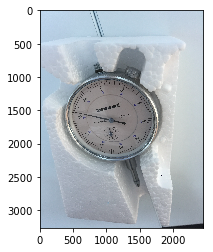

In [16]:
plt.imshow(img1)

# 6 tuning

In [18]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


In [19]:
def avg_circles(circles, b):
    avg_x=0
    avg_y=0
    avg_r=0
    for i in range(b):
        #optional - average for multiple circles (can happen when a gauge is at a slight angle)
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x/(b))
    avg_y = int(avg_y/(b))
    avg_r = int(avg_r/(b))
    return avg_x, avg_y, avg_r

In [20]:
img =cv2.imread("../Gauge/data/bias_noOffset.jpg")
height, width = img.shape[:2]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #convert to gray
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 80)

Radius    331 1073 1559
311 366


True

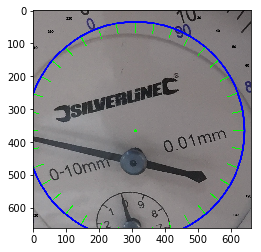

In [24]:
a, b, c = circles.shape
x,y,r = avg_circles(circles, b)
print("Radius   ", r, x, y)

#draw center and circle
cv2.circle(img, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)  # draw circle
cv2.circle(img, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)  # draw center of circle


icircle=circles[0,:][0]
cropSize = (r*2, r*2)
nx=x-int(icircle[0]-cropSize[1]//2)
ny=y-int(icircle[1]-cropSize[0]//2)

print(nx,ny)


cropCoords = (max(0, icircle[1]-cropSize[0]//2),min(img.shape[0], icircle[1]+cropSize[0]//2),
                  max(0, icircle[0]-cropSize[1]//2),min(img.shape[1], icircle[0]+cropSize[1]//2)) 
crop_cimg = img[int(cropCoords[0]):int(cropCoords[1]),int(cropCoords[2]):int(cropCoords[3])] 

plt.imshow(crop_cimg)


#for testing, output circles on image
#cv2.imwrite('gauge-%s-circles.%s' % (gauge_number, file_type), img)


#for calibration, plot lines from center going out at every 10 degrees and add marker
#for i from 0 to 36 (every 10 deg)

'''
goes through the motion of a circle and sets x and y values based on the set separation spacing.  Also adds text to each
line.  These lines and text labels serve as the reference point for the user to enter
NOTE: by default this approach sets 0/360 to be the +x axis (if the image has a cartesian grid in the middle), the addition
(i+9) in the text offset rotates the labels by 90 degrees so 0/360 is at the bottom (-y in cartesian).  So this assumes the
gauge is aligned in the image, but it can be adjusted by changing the value of 9 to something else.
'''
separation = 10.0 #in degrees
interval = int(360 / separation)
p1 = np.zeros((interval,2))  #set empty arrays
p2 = np.zeros((interval,2))
p_text = np.zeros((interval,2))
for i in range(0,interval):
    for j in range(0,2):
        if (j%2==0):
            p1[i][j] = x + 0.9 * r * np.cos(separation * i * 3.14 / 180) #point for lines
        else:
            p1[i][j] = y + 0.9 * r * np.sin(separation * i * 3.14 / 180)
text_offset_x = 10
text_offset_y = 5
for i in range(0, interval):
    for j in range(0, 2):
        if (j % 2 == 0):
            p2[i][j] = x + r * np.cos(separation * i * 3.14 / 180)
            p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos((separation) * (i+27) * 3.14 / 180) #point for text labels, i+9 rotates the labels by 90 degrees
        else:
            p2[i][j] = y + r * np.sin(separation * i * 3.14 / 180)
            p_text[i][j] = y + text_offset_y + 1.2* r * np.sin((separation) * (i+27) * 3.14 / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

#add the lines and labels to the image
for i in range(0,interval):
    cv2.line(img, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])),(0, 255, 0), 2)
    cv2.putText(img, '%s' %(int(i*separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,0,0),1,cv2.LINE_AA)

cv2.imwrite('../Gauge/processed/tilted-calibration.jpg', img)

#get user input on min, max, values, and units
#print ('gauge number: %s' %gauge_number)

# 7 Video transformation

In [26]:
import numpy as np
import cv2
 
# Read input video
cap = cv2.VideoCapture('../Gauge/data/straight_noOffset_Moving_1.avi')
fps    = cap.get(cv.CAP_PROP_FPS) 
# Get frame count
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 
 
# Get width and height of video stream
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
# Define the codec for output video
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
 
# Set up output video
out = cv2.VideoWriter('./Gauge/data/video_out.mp4', fourcc, fps, (w, h))

In [27]:
# Read first frame
_, prev = cap.read() 
 
# Convert frame to grayscale
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY) 

In [28]:
# Pre-define transformation-store array
transforms = np.zeros((n_frames-1, 3), np.float32) 
 
for i in range(n_frames-2):
  # Detect feature points in previous frame
  prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                     maxCorners=200,
                                     qualityLevel=0.01,
                                     minDistance=30,
                                     blockSize=3)
    
  # Read next frame
    success, curr = cap.read() 
    if not success: 
    break
    
    # Convert to grayscale
    curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY) 
    
    # Calculate optical flow (i.e. track feature points)
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None) 
    
    # Sanity check
    assert prev_pts.shape == curr_pts.shape 
    
    # Filter only valid points
    idx = np.where(status==1)[0]
    prev_pts = prev_pts[idx]
    curr_pts = curr_pts[idx]
    
    #Find transformation matrix
    m = cv2.estimateRigidTransform(prev_pts, curr_pts, fullAffine=False) #will only work with OpenCV-3 or less
    retval, out, inliers=cv.estimateAffine3D(prev_pts, curr_pts, [, out[, inliers[, ransacThreshold[, confidence]]]])


    # Extract traslation
    dx = m[0,2]
    dy = m[1,2]
    
    # Extract rotation angle
    da = np.arctan2(m[1,0], m[0,0])
    
    # Store transformation
    transforms[i] = [dx,dy,da]
    
    # Move to next frame
    prev_gray = curr_gray
    
    print("Frame: " + str(i) +  "/" + str(n_frames) + " -  Tracked points : " + str(len(prev_pts)))

AttributeError: module 'cv2.cv2' has no attribute 'estimateRigidTransform'